In [1]:
import numpy as np
import scipy
from sympy import Min, Max
%matplotlib inline
from devito import configuration
from devito import Grid, TimeFunction, Eq, Operator, Function, solve, norm, mmax
from devito.exceptions import InvalidArgument
from examples.seismic import plot_velocity, plot_perturbation, Model, AcquisitionGeometry, Receiver, plot_shotrecord \
, plot_image, TimeAxis, RickerSource
from examples.seismic.acoustic import AcousticWaveSolver
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 10.0)
configuration['log-level'] = 'WARNING'
# This added simply to reduce clutter in the output

# ACSE-7 Inversion & Optimisation - Part D (25 pts) <a class="tocSkip"></a>

This question covers lectures 9-11.

Please read the general instructions in [README.md](./README.md) first!

**IMPORTANT:** *This question covers the lectures on Full waveform inversion and Devito. It is advised to initially build and test your workflow on a small subset of the data - choose a combination of model size, shots and iterations such that you can execute the FWI workflow within a couple of minutes. Increase all these parameters to produce the final result. Note that, unless you have a very powerful computer, you should at no stage attempt to invert the entire data set. To obtain a good value for the objective function, your final configuration may take several hours to run so please be sure to begin executing this well before the submission deadline.*

# Question D: Full Waveform Inversion<a class="tocSkip"></a>

The data file provided, `vp_marmousi_bi`, contains $v_p$ data from the 2D Marmousi model, a synthetic model for testing FWI frameworks (see [here](http://mr.crossref.org/iPage?doi=10.1190%2F1.1437051)). The data set is of size $1601 \times 401$, you should use some suitable subset of this data when building your FWI workflow.

Your task is to build an FWI framework to recover the Marmousi model from an initial smoothed model. You may base the skeleton of the workflow on that presented in lecture 11.

**(i)** Load a suitable subset of the Marmousi model into a `numpy` array. Generate a smoothed model. Then plot (a) The true model, (b) The smoothed model and (c) their difference. Justify your choice of smoothed model.

**Note:** The `gaussian_filter` from `scipy.ndimage` will be useful for generating your smoothed model.

**(ii)** Devise an acquisition geometry. Plot this geometry, explain and justify your choice of source and receiver locations.

**(iii)** Now build and execute your FWI framework. Using the $L_2-norm$ of the residual data as your objective function, plot how it changes throughout the iteration procedure and plot the true model, final model and their difference.

**(iv)** Repeat (iii) using a different objective function. Briefly discuss your choice.

**(iv)** Discuss the limitations of the FWI workflow you have implemented and how it could be improved. Discuss also the additional difficulties you may encounter when dealing with a real (field) data set and how the above workflow could be adapted to account for some of these. **Please limit your answer to 400 words**.

**Total 25 Marks**

First we load data:

In [2]:
whole_data = np.fromfile("./vp_marmousi_bi", dtype = np.float32)
whole_data = whole_data.reshape((1601, 401))
print(whole_data)

[[1.5  1.5  1.5  ... 4.3  4.3  4.3 ]
 [1.5  1.5  1.5  ... 4.3  4.3  4.3 ]
 [1.5  1.5  1.5  ... 4.3  4.3  4.3 ]
 ...
 [1.5  1.5  1.5  ... 3.38 3.38 3.38]
 [1.5  1.5  1.5  ... 3.38 3.38 3.38]
 [1.5  1.5  1.5  ... 3.38 3.38 3.38]]


And plot out the whole_model:

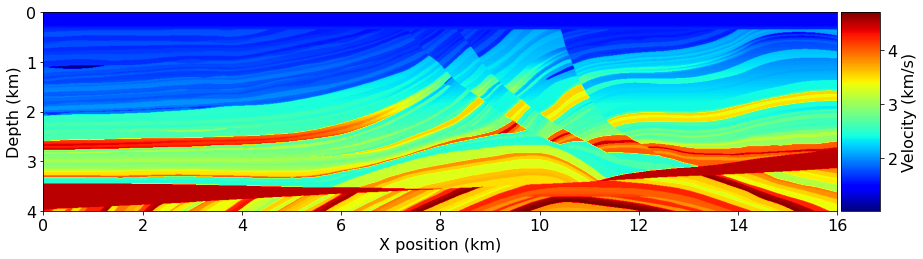

In [3]:
# Define a physical size
spacing = (10., 10)  # Grid spacing in m.
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 5 grid points
whole_model = Model(vp=whole_data, origin=origin, shape=whole_data.shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp")

plot_velocity(whole_model)

### Part(i)
(a)
To avoid too large computational cost, Let's choose a subset of the whole_model to be our true model, let's say the 
region in [ 7km, 9km ] $\times$ [ 1.75km, 2.25km ],

Which equals to a subgrid of 201 $\times$ 51 in the whole model:

In [4]:
data = whole_data[700:901, 175:226]
print(data.shape)

(201, 51)


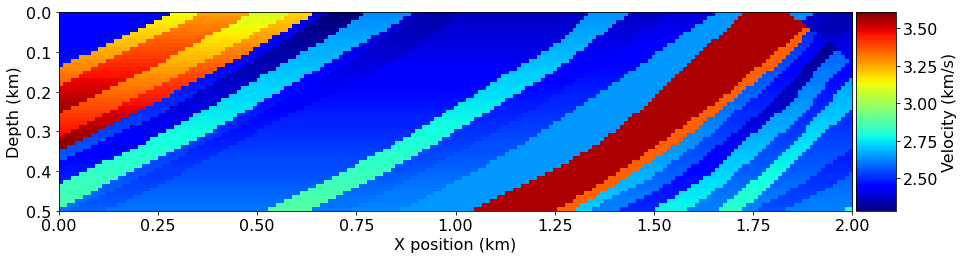

In [5]:
# Define a physical size
spacing = (10., 10)  # Grid spacing in m
origin = (0., 0.)  

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 20 grid points
true_model = Model(vp=data, origin=origin, shape=data.shape, spacing=spacing,
              space_order=2, nbl=20, bcs="damp")

plot_velocity(true_model)

(b)
Define smooth model, utilising the `gaussian_filter` module from `scipy.ndimage`, with a bigger $\sigma$ chosen, the model is much smoother because of the property of Gaussian_filter.

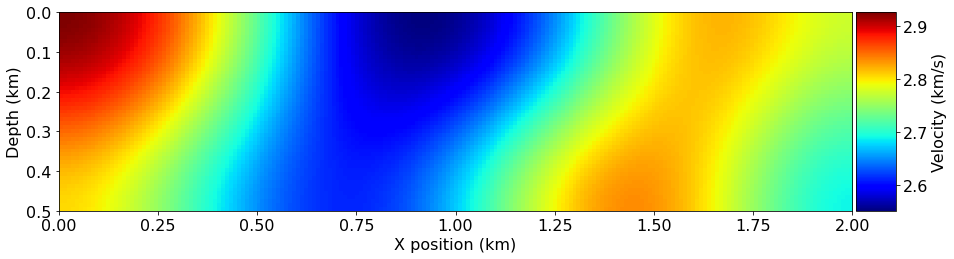

In [31]:
# use Gaussian_filter with sigma = 25 to generate a smooth model from the true model
smooth_data = gaussian_filter(data, sigma=25)

# same with the true model, we should use 20 grid points to create the absorbing layer
smooth_model = Model(vp=smooth_data, origin=origin, shape=data.shape, spacing=spacing,
             space_order=2, nbl=20, bcs="damp", grid = true_model.grid)

plot_velocity(smooth_model)

(c)
To whow their difference, we use the `plot_perturbation` function:

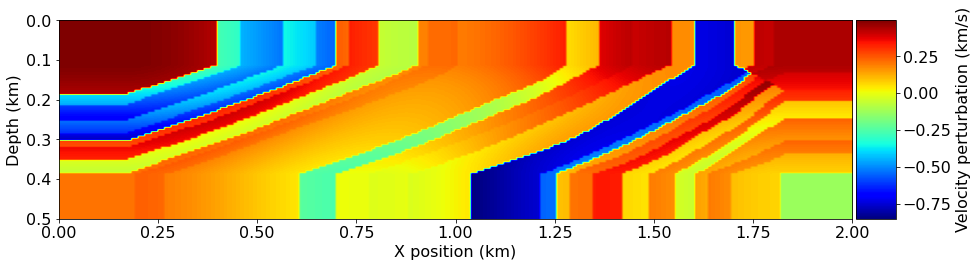

In [7]:
# plot the difference between our smooth model and the true model
plot_perturbation(smooth_model, true_model)

### Part(ii)

Then, we should devise an acquisition geometry, first just acquisition geometry for the source:

In [8]:
t0 = 0.  # Simulation starts a t=0
tn = 1000. 
f0 = 0.01  # Source peak frequency is 10Hz (0.010 kHz)

Since reflections usually lead to poor inversion results, I choose source(s) to be located on the upper side of the model and the receivers on the bottom side. This could allow most of the information necessary for inversion to be recorded.

In [9]:
# Position the source:
src_coordinates = np.empty((1, 2))

src_coordinates[0, 0] = np.array(true_model.domain_size[0]) * .5
src_coordinates[0, 1] = 490.

In [10]:
nreceivers = 101  # Number of receiver locations
# Prescribe even spacing for receivers along the up boundary
rec_coordinates = np.empty((nreceivers, 2))

rec_coordinates[:, 0] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 10.

Plot our Ricker source:

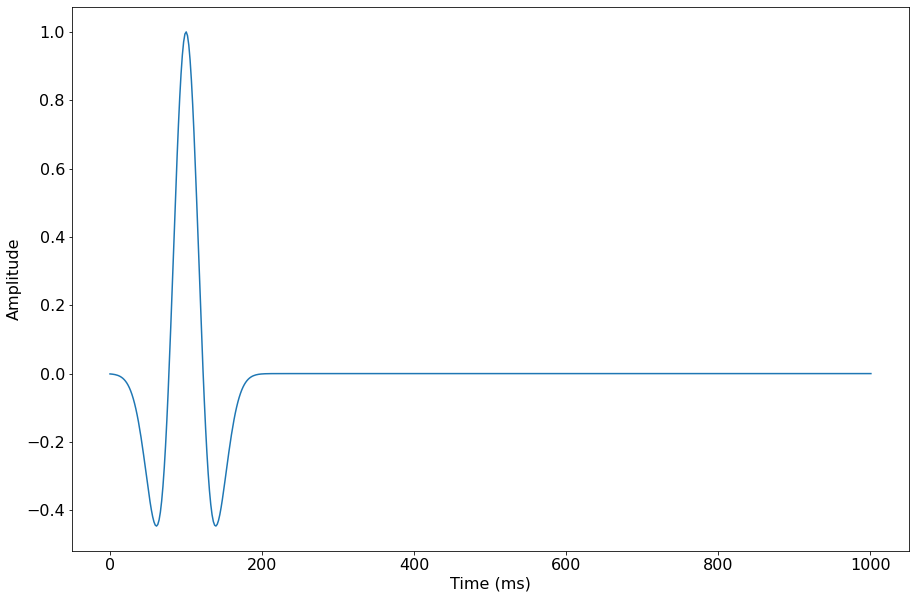

In [11]:
geometry = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

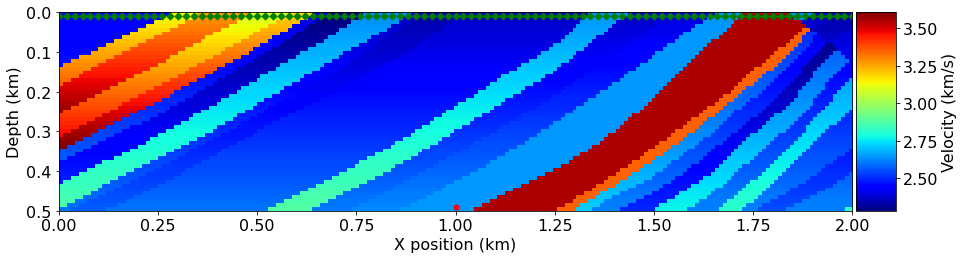

In [12]:
# Plot acquisition geometry
# We can now show the source and receivers within our domain:
# Red dot: Source location (at the bottom)

plot_velocity(true_model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::, :])

### Part(iii)

We plot a shotrecord for true and smooth velocity model and observe the difference:

In [13]:
# Compute synthetic data with forward operator 
solver = AcousticWaveSolver(true_model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=true_model.vp)
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=smooth_model.vp)

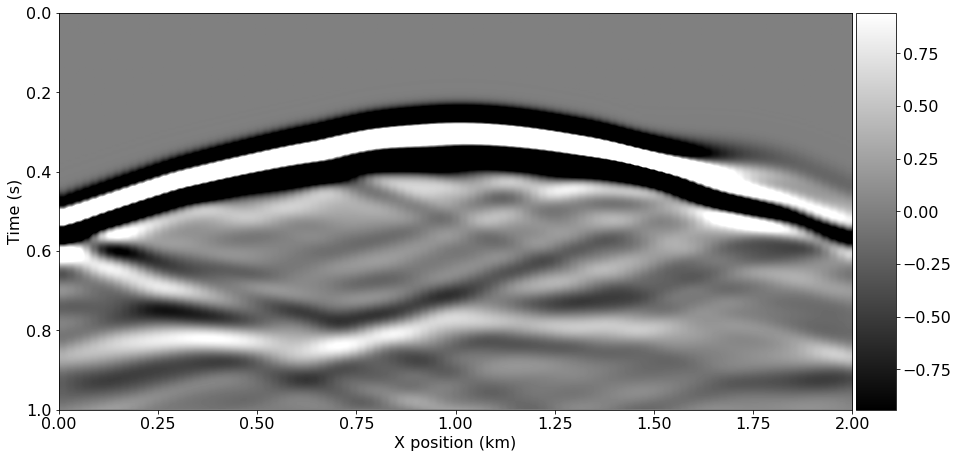

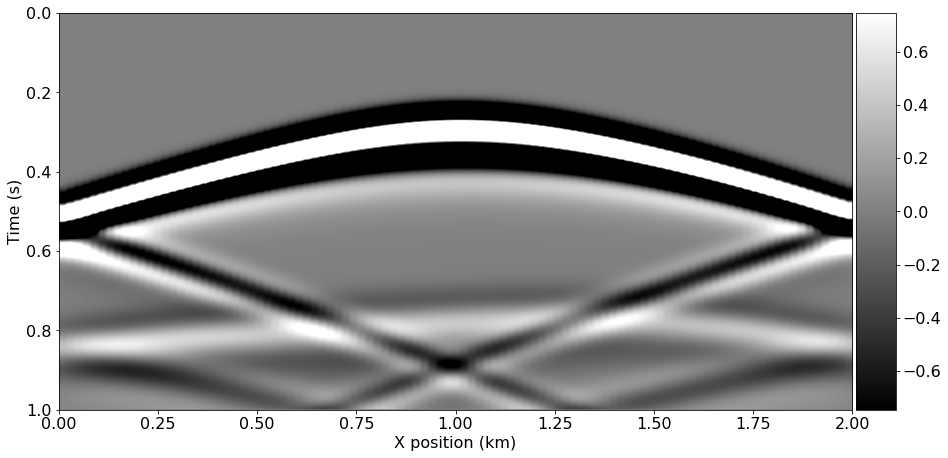

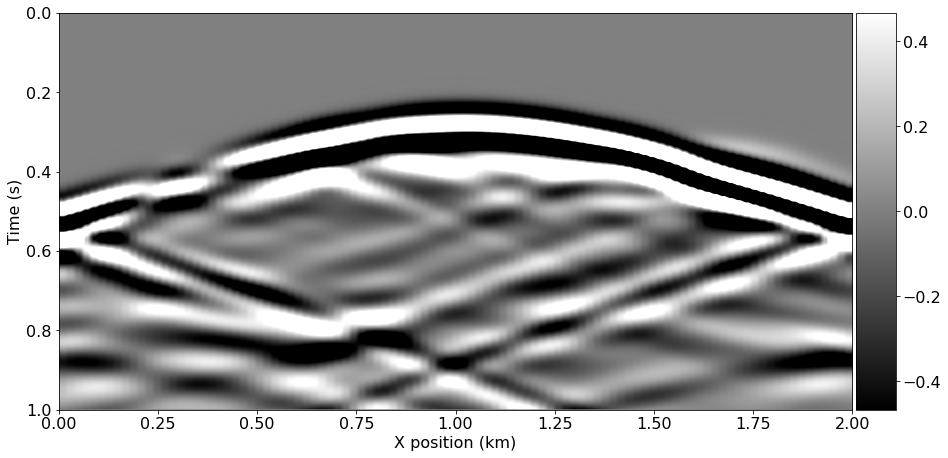

In [14]:
plot_shotrecord(true_d.data, true_model, t0, tn)
plot_shotrecord(smooth_d.data, true_model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, true_model, t0, tn)

We place multiple sources at the bottom, here I choose 19 shots to generate the gradient.

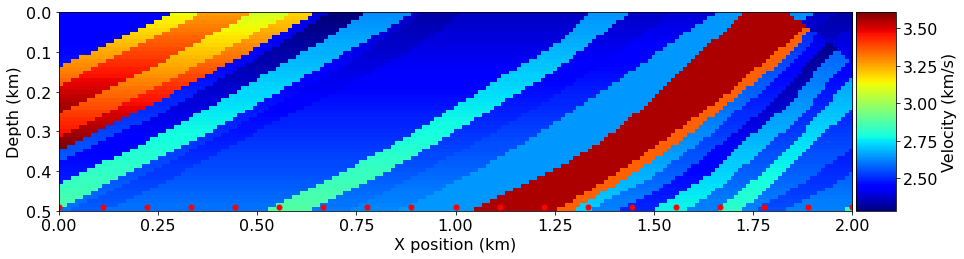

In [15]:
fwi_iterations = 1000  # Number of outer FWI iterations
nshots = 19  # Number of shots to used to generate the gradient
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 1] = 490. 
source_locations[:, 0] = np.linspace(0., true_model.domain_size[0], num=nshots)

plot_velocity(true_model, source=source_locations)

We implemented objective function $\Phi$ (from lecture 11) for multiple sources 
\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}
and the $\nabla\Phi_s$ (from lecture 11)  function to evaluate gradient, note that for multi-source datasets, the full gradient is a sum over all sources.

In [16]:
# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [17]:
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=true_model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=true_model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=true_model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=true_model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)

    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=true_model.vp, rec=d_obs)

        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)

        objective += .5* norm(residual)**2

        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
 
        
        
    return objective, grad

We first visualize gradient alongside the model perturbation and the effect of the gradient update on the model:

In [18]:
# Compute gradient of initial model
ff, update = fwi_gradient(smooth_model.vp)
print(ff)

395084.355700159


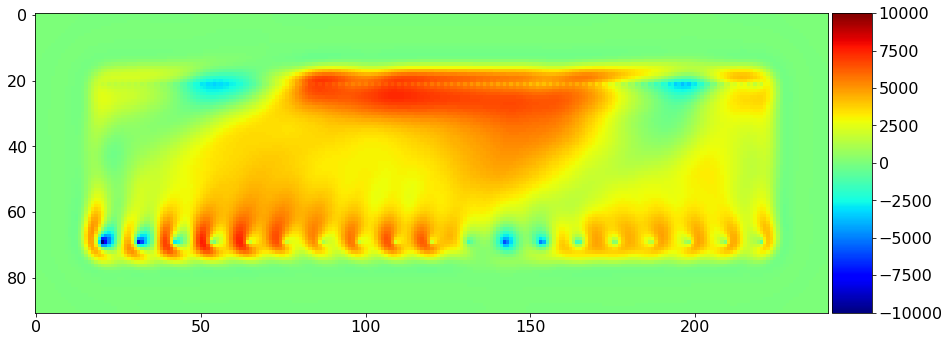

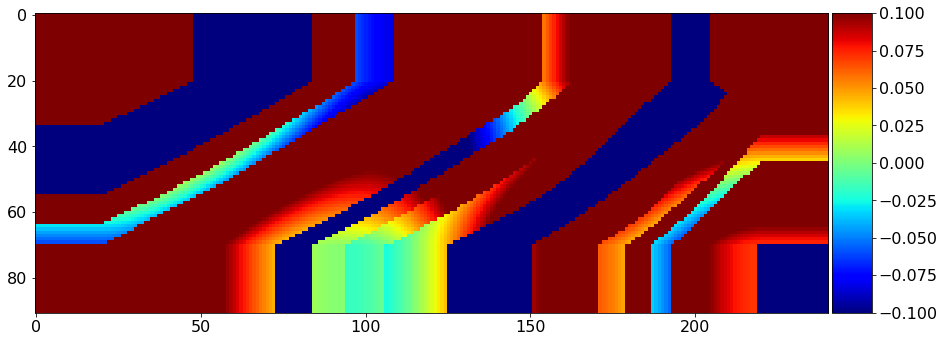

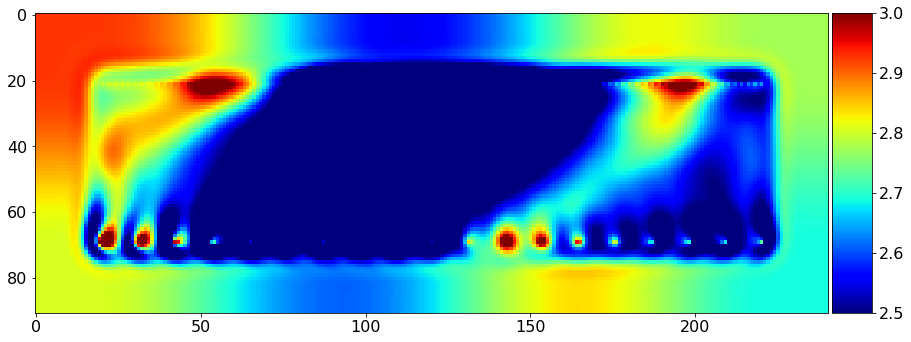

In [19]:
# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(smooth_model.vp.data - true_model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = 1 / mmax(update)
plot_image(smooth_model.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

In [20]:
def update_vp(vp, alpha, dm):
    """
    Apply gradient update in-place to vp
    """
    
    update = vp + alpha * dm
    update_eq = Eq(vp, update)
    Operator(update_eq)()

We perform a line-search (Wolfe condition)
\begin{align}
f(x^{(i)} + \lambda{\bf p}^{(i)}) - f(x^{(i)}) &\leq c_1 \lambda f'(x^{(i)})^T {\bf p}^{(i)} \\[10pt]
f'(x^{(i)} + \lambda{\bf p}^{(i)})^T{\bf p}^{(i)} &\leq c_2 f'(x^{(i)})^T {\bf p}^{(i)}
\end{align}
for the FWI inversion:

we set a default $\alpha = 1e-2$ and $\beta = 0.3$.

In [28]:
def line_search(x, p, phi, initial_slope, alpha=1e-2, beta = 0.3, max_search_iter=100):
    """Simple line search that halves lambda until the Wolfe condition is satisfied
    
    x - initial point (at lambda=0)
    p - search direction, search is along x+lambda*p
    f - (callback) function to minimize
    initial_slope - derivative of f in x in p-direction"""
    lamda = 0.5 / mmax(p)
    
    grad = Function(name="grad", grid=true_model.grid)  
    
    residual = Receiver(name='residual', grid=true_model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=true_model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=true_model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    
    print("-------------------entering line search-------------------------")
           
    if initial_slope==0.0:
        return 1.0, 0
    for j in range(max_search_iter):
        # print(np.all(smooth_model.vp.data == copy_model.vp.data))
        update_vp(smooth_model.vp, lamda, p)
        
        objective = 0.
        for i in range(nshots):
             # Update source location
            geometry.src_positions[0, :] = source_locations[i, :]

            _, _, _ = solver.forward(vp=true_model.vp, rec=d_obs)

        
            # Compute smooth data and full forward wavefield u0
            _, u0, _ = solver.forward(vp= smooth_model.vp, save=True, rec=d_syn)

        
            # Compute gradient from data residual and update objective function 
            compute_residual(residual, d_obs, d_syn)
            
            objective += .5* norm(residual)**2
            
            solver.gradient(rec=residual, u=u0, vp=smooth_model.vp, grad=grad)

        print("reductions: {0:}, current objective: {1:f}, objective before line_search: {2:f}".format(j, objective, phi))
        # check Wolfe condition:
        if objective - phi <= alpha*lamda*initial_slope and (np.sum(np.array(grad.data) * np.array(p.data)) \
        < beta * initial_slope or objective <= 0.85 * phi): 
            print("objective after line search {0:f},  with {1:} reductions, alpha = {2:f}" \
                  .format(objective, j, lamda))
            break
        # uncomment to follow convergence of line search:
        
        # go backward if reduction is needed
        update_vp(smooth_model.vp, -lamda, p)
        # print(np.all(smooth_model.vp.data == copy_model.vp.data))
        
        lamda *= (1 - beta)
        
        # Create placeholders for the data residual and data
        residual.data[...] = 0
        d_obs.data[...] = 0
        d_syn.data[...] = 0
    else:
        raise Exception("Line search did not converge")
    return objective, grad

In [32]:
# Number of outer FWI iterations
fwi_iterations = 1000
# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
# for i in range(0, fwi_iterations):
i = 0
# Compute the functional value and gradient for the current
phi, direction = fwi_gradient(smooth_model.vp)
while (phi > 1000):
    i = i + 1
    # model estimate
    print(phi)
    # Store the history of the functional values
    history[i] = phi
    
    # evaluate initial slope before line search
    intial_slope = np.sum(np.array(direction.data) * np.array(smooth_model.vp.data))
    print('initial slope: ', intial_slope)
    
    # performing line serach
    phi, direction= line_search(smooth_model.vp, direction, phi, intial_slope)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i))

395084.355700159
initial slope:  -100191440.0
-------------------entering line search-------------------------
reductions: 0, current objective: 345633.085119, objective before line_search: 395084.355700
objective after line search 345633.085119,  with 0 reductions, alpha = 0.000038
Objective value is 345633.085119 at iteration 1
345633.08511890576
initial slope:  103118850.0
-------------------entering line search-------------------------
reductions: 0, current objective: 328279.825306, objective before line_search: 345633.085119
objective after line search 328279.825306,  with 0 reductions, alpha = 0.000034
Objective value is 328279.825306 at iteration 2
328279.8253057811
initial slope:  -115934104.0
-------------------entering line search-------------------------
reductions: 0, current objective: 1428004.652735, objective before line_search: 328279.825306
reductions: 1, current objective: 827786.753930, objective before line_search: 328279.825306
reductions: 2, current objective: 32

KeyboardInterrupt: 

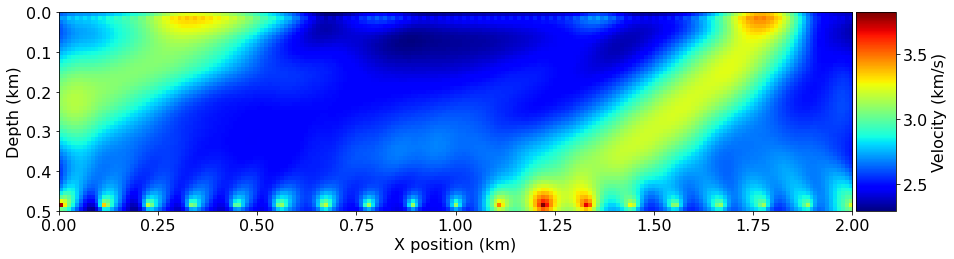

In [85]:
# Plot inverted velocity model
plot_velocity(smooth_model)